In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

17

In [3]:
! ls 'drive/My Drive/프로젝트/nlp'

data_check.ipynb      preprocessed_train_data.csv
gpt2_embedding.ipynb  train_filtered.csv


In [4]:
# hugging face install
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 59 kB 6.4 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 895 kB 36.3 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
# Install helper functions.
#!pip install -q git+https://github.com/gmihaila/ml_things.git

     |████████████████████████████████| 64 kB 1.8 MB/s 
     |████████████████████████████████| 11.2 MB 11.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
import io
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification,
                          GPT2LMHeadModel)

In [6]:
import tqdm 

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

import shutil

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cuda:0


**DATA 전처리**

In [7]:
path = 'drive/My Drive/프로젝트/nlp/preprocessed_train_data.csv'

In [8]:
data = pd.read_csv(path)

# 중복 데이터 제거
data.drop_duplicates('Lyrics')

,Genre,Lyrics
0,Rock,it starts with pain followed by hate fueled by...
1,Rock,freedom alone again again alone patiently wait...
2,Rock,biting the hand that feeds you lying to the vo...
3,Rock,you say you know just who i am but you can t i...
4,Rock,my heart is beating faster can t control these...
...,...,...
249943,R&B,i m the best friend he s got i d give him the ...
249944,Pop,bad boys blue i totally miss you i did you wro...
249945,Pop,forgive me for the things that i never said to...
249946,Indie,the day they found a cure for aids the day the...


In [ ]:
## over/under sampling

In [9]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3, random_state=123)

**Class**

In [10]:
## change class name!
## check 준현's code -- class LyricsAndGenreDataset(Dataset): 

# make dataset
# for Dataloader
# dataset shape : {'label': 'Pop', 'text': "Give me attention Too much distance\nTo measure it out (...) Is as lucky as us"}

class SongLyrics(Dataset):  
    def __init__(self, data, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.texts = []
        self.labels = []

        for row in data['Lyrics']:
          self.texts.append(row)
        
        for gen in data['Genre']:
          self.labels.append(gen)

        self.lyrics_count = len(self.labels)
        
    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        return {'text':self.texts[item],
                'label':self.labels[item]}

In [11]:
## LSTM 모델
## from : https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0
## 잘 안 되면 위에 링크로 다시 만들기.

## 준현이 거 가져옴
class TextLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, n_class, dropout):
    super(TextLSTM, self).__init__()
    
    self.lstm = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size,
              num_layers=num_layers,
              dropout=dropout,
              batch_first=True)

    self.dense = nn.Sequential(
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))

  def forward(self, hidden_and_cell, X):
    X = X.transpose(0, 1)
    outputs, hidden = self.lstm(X, hidden_and_cell)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    return self.dense(outputs)

**Hyperparameters**

In [20]:
## hyperparameters
# lstm_classifier = TextLSTM(v_dim, hidden_size, num_layers, n_genre, dropout).to(device)

set_seed(123)
epochs = 10
batch_size = 16

#### from 준현
#epoch = 2
lr = 0.0001
# batch_size = 4
# num_sentences = 2 # one sentence has 512 tokens
hidden_size = 128
num_layers = 4
dropout = 0

# v_dim?? dimention
v_dim = 768
n_genre = 10

####

# Pad or truncate text sequences to a specific length
## ! fix later
max_length = 500

model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'Rock': 0, 'Pop': 1, 'Metal': 2, 'Jazz': 3, 'Folk': 4, 'Indie': 5, 'R&B': 6, 'Hip-Hop': 7, 'Electronic': 8, 'Country': 9}
n_labels = len(labels_ids)

**DATA Embedding**

In [21]:
## gpt2 tokenizer와 model 가져오기
## 기존의 방식

# Get model configuration.
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
# model >> gpt2_model
gpt2_model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
gpt2_model.resize_token_embeddings(len(tokenizer))
gpt2_model.config.pad_token_id = gpt2_model.config.eos_token_id
gpt2_model.output_hidden_states=True

# Load model to defined device.
gpt2_model.to(device)
print('Model loaded to `%s`'%device)


## new??
## model과 tokenizer 가져오기

#tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')
#gpt2_embedding = torch.hub.load('huggingface/pytorch-transformers', 'model', 'gpt2').to(device)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda:0`


In [22]:

## train, test dataset 만들기
train_dataset = SongLyrics(train_data, truncate=True, gpt2_type="gpt2")
test_dataset = SongLyrics(test_data, truncate=True, gpt2_type="gpt2")


In [23]:
class Gpt2ClassificationCollator(object):

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [24]:

## dataset을 dataloader에 올리기

# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

## ?? collate_fn??
## gpt2_classification_collator의 역할도 잘 모르겠음.

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))


Created `train_dataloader` with 10936 batches!

Created `eval_dataloader` with 4687 batches!


In [16]:
"""
## for test
a_data, b_data = train_test_split(test_data, test_size=0.3, random_state=123)
train_dataset30 = SongLyrics(a_data, truncate=True, gpt2_type="gpt2")
test_dataset30 = SongLyrics(b_data, truncate=True, gpt2_type="gpt2")
train_dataloader30 = DataLoader(train_dataset30, batch_size=16, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader30))
print()
test_dataloader30 = DataLoader(test_dataset30, batch_size=16, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader30))
"""

Created `train_dataloader` with 11 batches!

Created `eval_dataloader` with 5 batches!


In [25]:
# 준현 코드 복붙함ㅎ

lstm_classifier = TextLSTM(v_dim, hidden_size, num_layers, n_genre, dropout).to(device)
loss_func = nn.CrossEntropyLoss()
params = list(lstm_classifier.parameters())
optimizer = optim.Adam(params, lr=lr)


**Train**

In [82]:
"""
## 실험용
juwoo = 0
true_labels = []

for batch in train_dataloader:
  if juwoo < 1:
    # label_batch : 실제 label 값
    print(batch)
    true_labels = batch['labels'].numpy().flatten().tolist()
    tk_batch = batch['input_ids']
    sg_batch = batch['attention_mask']
    # batch_size = 32 / max_length = 60
    print(true_labels) # len = 32
    print(tk_batch.shape) # torch.Size([32, 60])
    print(sg_batch.shape) # torch.Size([32, 60])

    #batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    with torch.no_grad():
      outputs = gpt2_model(**batch, output_hidden_states=True)
      loss, logits, past_key_values = outputs[:3]
      # print(logits.shape) # torch.Size([32, 10])
      # hidden_state = outputs.hidden_states
      hidden_state = outputs.hidden_states # tuple
      embedded_tokens = hidden_state[0]
      print(embedded_tokens.shape)
      print(embedded_tokens.shape[1])
      
      #print(hidden_states.shape)
      #, hidden_states, attentions


    #embedded_tokens = embedding[0].detach().view(batch_size,2**9*num_sentences,-1)
    #print(embedded_tokens.shape)
    juwoo += 1
"""

{'input_ids': tensor([[ 1219, 11752, 11752,  ...,   261,   618,  1312],
        [   83,   566,   257,  ...,  1528,   607, 35091],
        [  361,  1312,  1577,  ...,   481,   345, 19680],
        ...,
        [10755,  1194,   640,  ...,  5770,   339,   373],
        [   72,  1569,  1775,  ...,   428,  1692, 17968],
        [31373, 11854,   616,  ...,  7335,   286,   257]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([1, 5, 1, 1, 9, 0, 0, 2, 1, 2, 0, 1, 0, 1, 9, 1, 0, 1, 1, 0, 0, 1, 3, 0,
        4, 3, 0, 4, 1, 1, 2, 0])}
[1, 5, 1, 1, 9, 0, 0, 2, 1, 2, 0, 1, 0, 1, 9, 1, 0, 1, 1, 0, 0, 1, 3, 0, 4, 3, 0, 4, 1, 1, 2, 0]
torch.Size([32, 60])
torch.Size([32, 60])
torch.Size([32, 60, 768])
60


KeyboardInterrupt: ignored

In [26]:
## 준현이 코드
## how to change code into gpt2 version?
running_loss = 0.0
valid_running_loss = 0.0

num = round(len(train_dataloader)/len(test_dataloader))

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []


for epoch in range(epochs):
  # b : epoch 안에서 몇 번째 batch인지
  # ! batch : 출력으로 체크해볼 것.
  b = 0
  ## 1. gpt2에 embedding하기.
  for batch in train_dataloader:
    b += 1
    # label_batch : 실제 label 값
    true_labels = batch['labels'].to(device) #.numpy().flatten().tolist()
    # print(true_labels)
    # batch_size = 32 / max_length = 60
    # tk_batch = batch['input_ids'] # torch.Size([32, 60])
    # sg_batch = batch['attention_mask'] # torch.Size([32, 60])

    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

    with torch.no_grad():
      outputs = gpt2_model(**batch, output_hidden_states=True)
      loss, logits = outputs[:2]
      # logits : 각 확률
      # print(logits.shape) # torch.Size([32, 10])
      hidden_state = outputs.hidden_states # tuple 13개 (13개의 layer)
      # hidden_state_01 = hidden_state[0]
      # print(hidden_state_01.shape)

    # embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)
    embedded_tokens = hidden_state[0]

    ## torch.zeros(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor
    # ! embedded_token이 무엇인지 확인해야겠네.
    hidden = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    cell = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    output = lstm_classifier.forward((hidden, cell), embedded_tokens)
    optimizer.zero_grad()
    loss = loss_func(output, true_labels)
    loss.backward()
    optimizer.step()


    if b%num == 0:
      train_loss_list.append(float(loss.detach().cpu().data))
      pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
      acc = np.mean(pred == true_labels.detach().cpu().numpy().flatten())
      train_acc_list.append(float(acc))



  # test 진행하기.
  for batch in test_dataloader:
    # label_batch : 실제 label 값
    true_labels = batch['labels'].to(device) # .numpy().flatten().tolist()

    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

    with torch.no_grad():
      outputs = gpt2_model(**batch, output_hidden_states=True)
      loss, logits = outputs[:2]
      # logits : 각 확률
      # print(logits.shape) # torch.Size([32, 10])
      hidden_state = outputs.hidden_states # tuple 13개 (13개의 layer)
      # hidden_state_01 = hidden_state[0]
      # print(hidden_state_01.shape)

    # embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)
      embedded_tokens = hidden_state[0]
      output = lstm_classifier.forward((hidden, cell), embedded_tokens)
      optimizer.zero_grad()
      loss = loss_func(output, true_labels)

    ####
    predict_content = output.argmax(axis=-1).flatten().tolist()

    val_loss_list.append(float(loss.detach().cpu().data))
    pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
    acc = np.mean(pred == true_labels.detach().cpu().numpy().flatten())
    val_acc_list.append(float(acc))

    
  print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
                      .format(epoch+1, epochs, train_loss_list[-1], train_acc_list[-1], val_loss_list[-1], val_acc_list[-1]))

KeyError: ignored

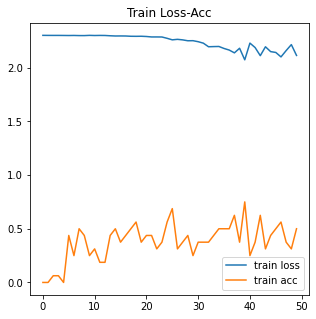

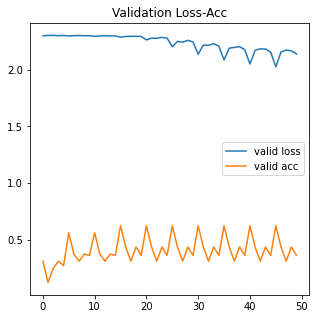

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.title('Train Loss-Acc')
plt.plot(train_loss_list, label='train loss')
plt.plot(train_acc_list, label='train acc')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.title('Validation Loss-Acc')
plt.plot(val_loss_list, label='valid loss')
plt.plot(val_acc_list, label='valid acc')
plt.legend()
plt.show()

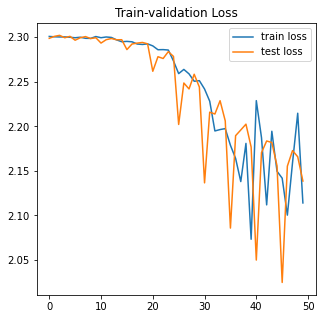

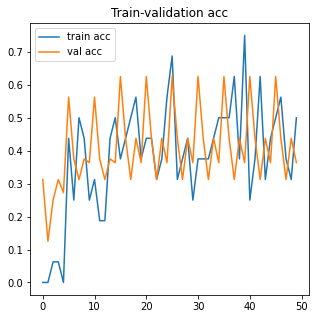

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.title('Train-validation Loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='test loss')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.title('Train-validation acc')
plt.plot(train_acc_list, label='train acc')
plt.plot(val_acc_list, label='val acc')
plt.legend()
plt.show()